In [1]:
'''
Assignment-2 
Name: Mohit Shailesh Kulkarni
UTA ID: 1002031021
References: 
https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320
https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/
https://datahacker.rs/lenet-5-implementation-tensorflow-2-0/
'''
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime 

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummaryX import summary as summaryX
from torchsummary import summary

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # This is for the trainning from GPU or CPU

In [3]:
device

'cpu'

In [4]:
transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.MNIST(root='DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST(root='DATA_MNIST/', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

In [5]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(images.shape)
print(labels.shape)

testing_data = enumerate(testloader)
batch_idx, (images, labels) = next(testing_data)
print(images.shape)
print(labels.shape)


torch.Size([64, 1, 32, 32])
torch.Size([64])
torch.Size([64, 1, 32, 32])
torch.Size([64])


In [6]:

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, 10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, out):
    out = self.conv1(out)
    out = self.tanh(out)
    out = self.avgpool(out)
    out = self.conv2(out)
    out = self.tanh(out)
    out = self.avgpool(out)
    out = self.conv3(out)
    out = self.tanh(out)
    
    out = out.reshape(out.shape[0], -1)
    out = self.linear1(out)
    out = self.tanh(out)
    out = self.linear2(out)
    return out

model = LeNet5()
out = torch.randn(64,1,32,32)
output = model(out)

print(model)
summary(model, (1,32,32))
print("output.shape : ",output.shape)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (tanh): Tanh()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8       

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
epochs = 14
train_loss, val_loss = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    total = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainloader):

        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total1 = 0
    for idx, (image, label) in enumerate(testloader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total1 = total1 + 1

    train_acc = 100 * total / train_data_size
    valid_acc = 100 * total1 / test_data_size

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 1 == 0:
        print(f'{datetime.now().time().replace(microsecond=0)} --- ''\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_val_loss, train_acc, valid_acc))

01:42:21 --- 
Epoch: 0/14, Train Loss: 0.2957, Val Loss: 0.1002, Train Acc: 91.1283, Val Acc: 96.9400
01:42:47 --- 
Epoch: 1/14, Train Loss: 0.0894, Val Loss: 0.0693, Train Acc: 97.2483, Val Acc: 97.8800
01:43:12 --- 
Epoch: 2/14, Train Loss: 0.0609, Val Loss: 0.0489, Train Acc: 98.1233, Val Acc: 98.5300
01:43:37 --- 
Epoch: 3/14, Train Loss: 0.0444, Val Loss: 0.0459, Train Acc: 98.5933, Val Acc: 98.5400
01:44:03 --- 
Epoch: 4/14, Train Loss: 0.0366, Val Loss: 0.0484, Train Acc: 98.8917, Val Acc: 98.4000
01:44:28 --- 
Epoch: 5/14, Train Loss: 0.0304, Val Loss: 0.0509, Train Acc: 98.9850, Val Acc: 98.4600
01:44:53 --- 
Epoch: 6/14, Train Loss: 0.0258, Val Loss: 0.0469, Train Acc: 99.1783, Val Acc: 98.5200
01:45:18 --- 
Epoch: 7/14, Train Loss: 0.0213, Val Loss: 0.0479, Train Acc: 99.3000, Val Acc: 98.6000
01:45:42 --- 
Epoch: 8/14, Train Loss: 0.0185, Val Loss: 0.0502, Train Acc: 99.4300, Val Acc: 98.6200
01:46:08 --- 
Epoch: 9/14, Train Loss: 0.0154, Val Loss: 0.0490, Train Acc: 99.501

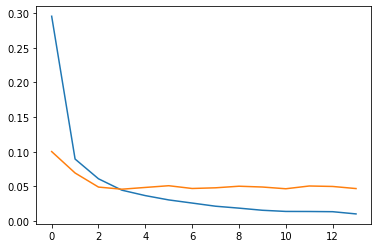

In [9]:
plt.plot(train_loss)
plt.plot(val_loss)

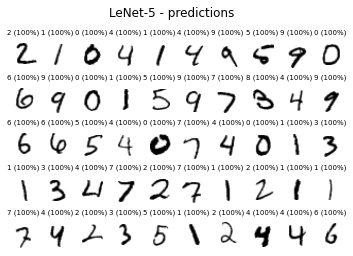

In [10]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_set.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        probs = model(test_set[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} (100%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');